Note: Each model is presented as an independent section for better isolation and ease of understanding

In [1]:
def get_metrics(labels, preds):
    data_metrics = []
    for metric in metrics:
        metric_name = metric.__name__
        if metric_name == "accuracy_score":
            data_metrics.append((metric_name, metric(labels, preds)))
        else:
            data_metrics.append((metric_name, metric(labels, preds, average="macro")))

    return pd.DataFrame(data_metrics, columns=["metric", "value"])

# Baseline
Before conducting any experiments, it's important to establish a simple baseline. This helps in making decisions about the model performance in the early stages of development

In [2]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [3]:
plt.style.use("ggplot")

In [4]:
df_test = pd.read_csv("preds/mfcc-test.csv")
print(len(df_test))
df_test.head()

1310


,filename,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,164797-2-0-50.wav,children_playing,8.866575e-01,0.000009,3.810622e-02,0.029240,0.000039,3.133511e-03,1.770535e-03,3.316693e-09,0.021471,0.019573
1,17578-5-0-23.wav,engine_idling,5.985906e-05,0.000453,1.342414e-03,0.000029,0.002079,9.932372e-01,1.256412e-07,1.857425e-03,0.000045,0.000897
2,207214-2-0-26.wav,children_playing,1.128041e-02,0.002365,5.206296e-01,0.112187,0.049140,1.356505e-02,1.159514e-01,7.473872e-04,0.024246,0.149889
3,14470-2-0-14.wav,children_playing,8.298853e-06,0.000204,8.744751e-01,0.038185,0.012411,1.595363e-03,1.817845e-02,1.478383e-06,0.033734,0.021208
4,93567-8-0-17.wav,siren,1.277176e-15,0.307760,2.747113e-15,0.000004,0.000003,8.254789e-11,3.924732e-10,3.239344e-14,0.692206,0.000027


In [5]:
classes = df_test.label.sort_values().unique()

In [6]:
metrics = [precision_score, recall_score, f1_score, accuracy_score]

In [7]:
preds = df_test[classes].idxmax(axis=1)

In [8]:
get_metrics(df_test.label, preds)

,metric,value
0,precision_score,0.693671
1,recall_score,0.665230
2,f1_score,0.670525
3,accuracy_score,0.690840


This is a decent baseline to compare our models against.

# Zero Shot (CLAP) Evaluation

In [9]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [10]:
plt.style.use("ggplot")

In [11]:
df_test = pd.read_csv("preds/clap-test.csv")
print(len(df_test))
df_test.head()

1310


,filename,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,164797-2-0-50.wav,children_playing,2.943992e-03,0.008064,0.952775,4.795736e-04,0.000026,0.000759,0.000759,0.000116,0.005448,0.028630
1,17578-5-0-23.wav,engine_idling,2.189460e-02,0.000205,0.000026,1.846368e-04,0.000476,0.965558,0.000054,0.011473,0.000051,0.000077
2,207214-2-0-26.wav,children_playing,3.995908e-06,0.000179,0.992761,2.809861e-06,0.000009,0.000101,0.000042,0.000007,0.000857,0.006037
3,14470-2-0-14.wav,children_playing,9.924141e-08,0.000002,0.999881,4.821749e-07,0.000002,0.000003,0.000018,0.000042,0.000008,0.000044
4,93567-8-0-17.wav,siren,1.587656e-06,0.006024,0.000153,1.106603e-04,0.000015,0.000010,0.000009,0.000016,0.984928,0.008732


In [12]:
classes = df_test.label.sort_values().unique()

In [13]:
metrics = [precision_score, recall_score, f1_score, accuracy_score]

## Selecting the class with the highest probability
The simplest approach to assign classes from the model predictions would be to take the class with the maximum probability

In [14]:
preds = df_test[classes].idxmax(axis=1).to_numpy()

In [15]:
get_metrics(df_test.label, preds)

,metric,value
0,precision_score,0.789655
1,recall_score,0.748847
2,f1_score,0.743472
3,accuracy_score,0.740458


For a zero-shot setting, these are suprisingly good numbers. Without any data provided to the model, it was able to correctly identify the classes in 3/4ths of the test dataset. It even beats the MFCC baseline

## Selecting with threshold
A potentially better way of improving the model performance would be use a threshold to filter out predictions where the model is not confident in it's predictions.  
We can use a PR curve to determine this threshold. 

Since we don't want to overfit on the test set, we'll use the validation set for this task

In [16]:
df_valid = pd.read_csv("preds/clap-valid.csv")
print(len(df_valid))
df_valid.head()

1310


,filename,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,49312-2-0-16.wav,children_playing,0.000002,0.000055,0.998321,0.000009,0.000008,0.000026,0.000020,0.000058,0.000319,0.001182
1,169466-4-3-9.wav,drilling,0.001141,0.007098,0.070889,0.002817,0.007584,0.017082,0.074979,0.751844,0.022784,0.043782
2,39884-5-0-1.wav,engine_idling,0.002819,0.009947,0.000048,0.000188,0.000043,0.986275,0.000053,0.000401,0.000083,0.000142
3,167701-4-6-4.wav,drilling,0.001359,0.214464,0.002815,0.001745,0.308239,0.056742,0.000485,0.388747,0.022160,0.003244
4,24347-8-0-48.wav,siren,0.000002,0.005404,0.000871,0.000463,0.000141,0.000293,0.000019,0.000097,0.914580,0.078131


In [17]:
data = df_valid[classes].to_numpy()

labels = df_valid["label"].tolist()
labels_sparse = np.zeros((len(labels), len(classes)))
for i in range(len(labels)):
    labels_sparse[i] = (classes == labels[i])

In [18]:
thresholds = [0.01, 0.05] + np.linspace(0.1, 0.9, 9).tolist() + [0.95, 0.99]

In [19]:
precisions, recalls = [], []

for threshold in tqdm(thresholds):
    preds = data > threshold
    precisions.append(precision_score(labels_sparse, preds, average="micro"))
    recalls.append(recall_score(labels_sparse, preds, average="micro"))


  0%|          | 0/13 [00:00<?, ?it/s]

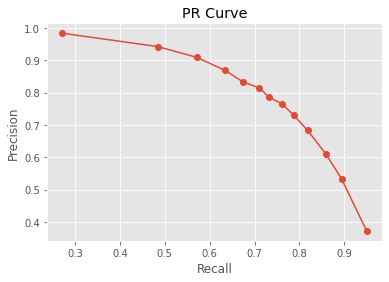

In [20]:
fig, ax = plt.subplots(1, 1)

ax.plot(recalls, precisions, marker='o')

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")

ax.set_title("PR Curve");

We can see that the point corresponding to thresholds 0.5 and 0.6 seem to have the best performance

In [21]:
threshold = 0.55
preds = data > threshold
get_metrics(labels_sparse, preds)

,metric,value
0,precision_score,0.854083
1,recall_score,0.729168
2,f1_score,0.761264
3,accuracy_score,0.725191


This approach improved the precision with only a slight drop in recall. Consequently, the F1 score also improved. This makes sense as the classification system is now more conservative in it's estimates compared to the earlier version

Depending on the task at hand, the loss in recall might be an acceptable trade-off

# Wav2Vec2 Evaluation

In [22]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [23]:
plt.style.use("ggplot")

In [24]:
df_test = pd.read_csv("preds/wav2vec2-test.csv")
print(len(df_test))
df_test.head()

1310


,filename,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,164797-2-0-50.wav,children_playing,0.103794,0.025038,0.001672,0.009792,0.083255,0.198738,0.000610,0.567548,0.008192,0.001363
1,17578-5-0-23.wav,engine_idling,0.130853,0.010763,0.000530,0.002195,0.325663,0.178256,0.000008,0.350398,0.000610,0.000723
2,207214-2-0-26.wav,children_playing,0.047430,0.137011,0.091758,0.021810,0.282318,0.044008,0.005486,0.324151,0.025153,0.020877
3,14470-2-0-14.wav,children_playing,0.017578,0.089363,0.394020,0.032699,0.047640,0.020995,0.001783,0.010209,0.149561,0.236151
4,93567-8-0-17.wav,siren,0.004804,0.077267,0.043750,0.029088,0.043984,0.032997,0.000891,0.006753,0.757135,0.003332


In [25]:
classes = df_test.label.sort_values().unique()

In [26]:
metrics = [precision_score, recall_score, f1_score, accuracy_score]

In [27]:
preds = df_test[classes].idxmax(axis=1)

In [28]:
get_metrics(df_test.label, preds)

,metric,value
0,precision_score,0.509989
1,recall_score,0.441267
2,f1_score,0.433847
3,accuracy_score,0.435878


This performance clearly leaves a lot to be desired, let's take a look where the model fails by calculating the metrics at class level

In [29]:
pd.DataFrame(list(zip(
    classes, 
    precision_score(df_test.label, preds, average=None),
    recall_score(df_test.label, preds, average=None),
    f1_score(df_test.label, preds, average=None),

)), columns=["class", "precision", "recall", "f1-score"]).sort_values("f1-score").reset_index(drop=True)

,class,precision,recall,f1-score
0,car_horn,0.204545,0.130435,0.159292
1,air_conditioner,0.522727,0.138554,0.219048
2,engine_idling,0.246201,0.574468,0.344681
3,drilling,0.294118,0.547945,0.382775
4,street_music,0.745098,0.260274,0.385787
5,children_playing,0.612500,0.322368,0.422414
6,jackhammer,0.421875,0.574468,0.486486
7,gun_shot,0.589286,0.687500,0.634615
8,siren,0.739130,0.559211,0.636704
9,dog_bark,0.724409,0.617450,0.666667


The low precision score for classes like car_horn, engine_idling and drilling tells us that the model is often conflating other classes with them.

Making a confusion matrix can help us get more information about this

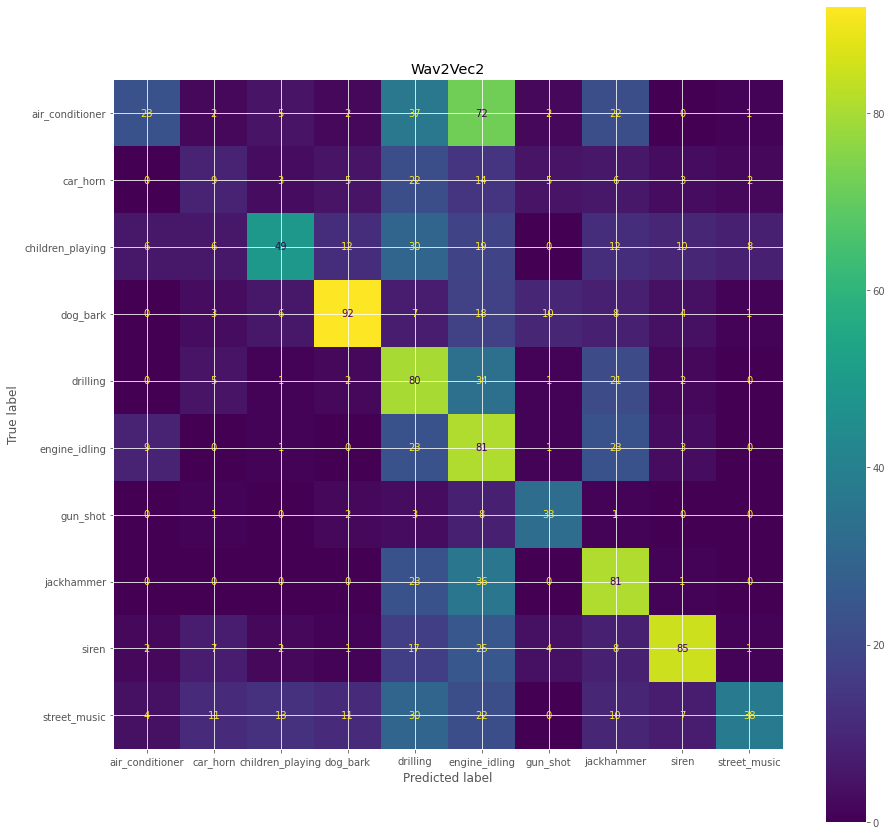

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.set_title("Wav2Vec2")

ConfusionMatrixDisplay(confusion_matrix(df_test.label, preds), display_labels=classes).plot(ax=ax)

As suspected, the model is often classifying inputs as drilling and engine_idling. 

# MIT-AudioSet Evaluation

In [31]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [32]:
plt.style.use("ggplot")

In [33]:
df_test = pd.read_csv("preds/mit-test.csv")
print(len(df_test))
df_test.head()

1310


,filename,label,air_conditioner,car_horn,children_playing,dog_bark,drilling,engine_idling,gun_shot,jackhammer,siren,street_music
0,164797-2-0-50.wav,children_playing,0.003709,0.000305,0.987794,0.001612,0.000068,0.003563,0.000063,0.000093,0.000331,0.002462
1,17578-5-0-23.wav,engine_idling,0.027785,0.000359,0.000190,0.000461,0.011460,0.871870,0.000017,0.087416,0.000094,0.000348
2,207214-2-0-26.wav,children_playing,0.002041,0.000513,0.879849,0.003092,0.000306,0.000149,0.000042,0.000085,0.000412,0.113512
3,14470-2-0-14.wav,children_playing,0.000044,0.000197,0.979027,0.000629,0.002236,0.000090,0.000293,0.000199,0.000099,0.017187
4,93567-8-0-17.wav,siren,0.000010,0.000219,0.000096,0.000051,0.000088,0.000029,0.000003,0.000007,0.999467,0.000032


In [34]:
classes = df_test.label.sort_values().unique()

In [35]:
metrics = [precision_score, recall_score, f1_score, accuracy_score]

In [36]:
preds = df_test[classes].idxmax(axis=1)

In [37]:
get_metrics(df_test.label, preds)

,metric,value
0,precision_score,0.940528
1,recall_score,0.935904
2,f1_score,0.937890
3,accuracy_score,0.936641


The performance here is significantly better

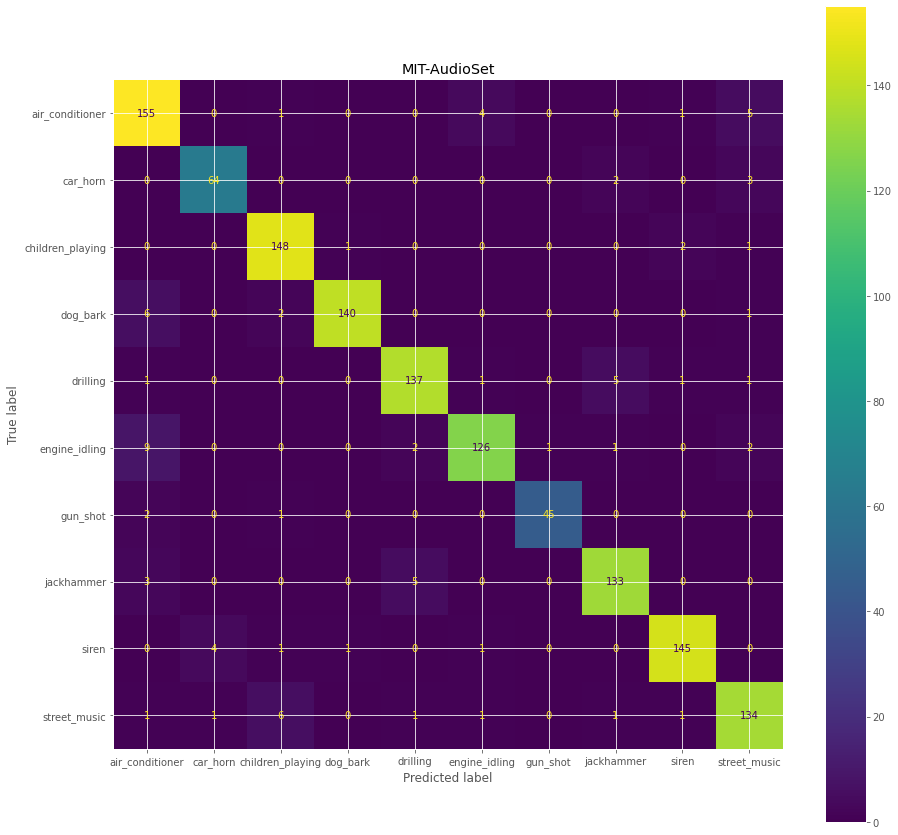

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

ax.set_title("MIT-AudioSet")

ConfusionMatrixDisplay(confusion_matrix(df_test.label, preds), display_labels=classes).plot(ax=ax)

The confusion matrix confirms this with the almost perfect diagonal